In this notebook we will try to study the performance of our estimator with respect to the benchmark _Stack_Loss_ dataset. The following notebook can be used to replicate the experiment on the paper by simply running the cells.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import statsmodels.api as sm
import sys
sys.path.insert(1, "./../PSIS/py/")
import psis
sys.path.insert(1, "../")
import models

In [2]:
data=sm.datasets.stackloss.load_pandas().data
data
y = data.loc[::, "STACKLOSS"].values
X = data.loc[:: ,"AIRFLOW":"ACIDCONC"].values

In [4]:
## Let us standardize the covariates now
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
## Center the y --> equal to flat prior on intercept
y = y-np.mean(y)

n,p = X.shape
sigma_p = 100
sample_cov = np.dot(X, X.transpose())
variances=np.linspace(1 ,20,1000)

In [5]:
def marginal_likelihood(var, var_p, y, sample_cov):
    marginal_cov = var*(var_p*sample_cov + np.eye(sample_cov.shape[0]))
    return multivariate_normal(mean=np.zeros(sample_cov.shape[0]), cov=marginal_cov).pdf(y)

In [6]:
pdfs=np.zeros(1000)
iterator=0
for var in variances:
    pdfs[iterator]=marginal_likelihood(var, sigma_p/p, y, sample_cov)
    iterator+=1

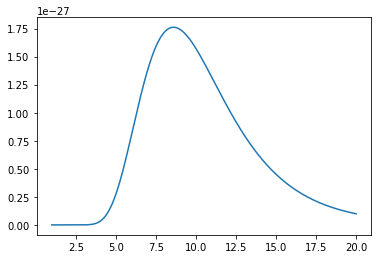

In [7]:
plt.plot(variances, pdfs)

In [8]:
index = np.argmax(pdfs)
max_var = variances[index]
max_var

8.588588588588589

In [9]:
sigma_0=var*100/p*np.identity(p)
theta_0=np.zeros((p,1))
var = max_var
model = models.Gaussian_Model(y, X, theta_0, sigma_0, var)

## Let us move to estimation

In [52]:
############# DICTIONARIES WHERE WE WILL SAVE THE RESULTS #####################
estimates_posterior_nd = {}
estimates_mix_nd = {}
estimates_psis_nd = {}
correct_values_nd = {}

############ EXPERIMENT PARAMETERS ####################################
attempts = 1000
iterations = 5000

#################################################################
n,p = X.shape
theta_0=np.zeros((p,1))
variances=np.linspace(max_var-3, max_var+3, 11)

#################################################################    
for var in variances:
    sigma_0=var*100/p*np.identity(p)
    
    ########### The following code is just to ensure a stable sampling for the mixture ##############
    model_full = models.Gaussian_Model(y, X, theta_0, sigma_0, var)
    Models = [models.Gaussian_Model(np.concatenate([y[0:index], y[index+1:]]),
                np.concatenate([X[0:index], X[index+1:]]),
               theta_0, sigma_0, var) for index in range(n)]
    full = model_full.log_p_full()
    leave_one_outs_p = np.array([full - model_full.log_predictive_i(index) for index in range(n)])
    minimum = leave_one_outs_p.min()
    normalizer = np.sum(np.exp(leave_one_outs_p-minimum))
    weights = np.exp(leave_one_outs_p-minimum)/normalizer
    res=np.random.multinomial(iterations,weights)
    loos = [Models[index].cond_theta() for index in range(n)]
    correct_values = np.array([np.sum(model_full.log_predictive_i(k)) for k in range(n)])
    for attempt in range(attempts):
        print("I am at attempt:" + str(attempt) + "\tvar: "+str(var), end="\r")
        thetas_mixture=np.zeros((X.shape[1],iterations))
        index=0
        for j in range(n):
            if res[j] > 0:
                if res[j] == 1:
                    thetas_mixture[::, index]=(loos[j].rvs(size=res[j]).transpose())
                    index+=res[j]
                else:
                    thetas_mixture[::, index:index+res[j]]=(loos[j].rvs(size=res[j]).transpose())
                    index+=res[j]

        posterior = model_full.cond_theta()
        thetas_posterior=posterior.rvs(size=iterations).transpose() 
        
        ###################### Creating the estimators ########################
        is_estimator = models.Is_estimators(model_full)
        key = f"(n:{n}, p:{p}, var:{var})"
        if attempt==0:
            estimates_posterior_nd[key] = is_estimator.posterior(thetas_posterior).reshape((1,n))
            estimates_mix_nd[key] = is_estimator.mixture(thetas_mixture).reshape((1,n))
            estimates_psis_nd[key] = is_estimator.PSIS(thetas_posterior).reshape((1,n))
            correct_values_nd[key] = correct_values.reshape((1,n))

        else:
            estimates_posterior_nd[key] = np.concatenate([estimates_posterior_nd[key], is_estimator.posterior(thetas_posterior).reshape((1,n))], axis=0)
            estimates_mix_nd[key] = np.concatenate([estimates_mix_nd[key], is_estimator.mixture(thetas_mixture).reshape((1,n))],axis=0)
            estimates_psis_nd[key]= np.concatenate([estimates_psis_nd[key], is_estimator.PSIS(thetas_posterior).reshape((1,n))],axis=0)


## Let us plot the results now

In [53]:
##Let us calculate the rmses at the different iterations
rmses_mix = np.zeros((n, len(variances)))
rmses_post = np.zeros((n, len(variances)))
rmses_psis = np.zeros((n, len(variances)))
index = 0
for var in variances:
    key = f"(n:{n}, p:{p}, var:{var})"
    rmses_mix[::, index] = np.sqrt(np.mean((estimates_mix_nd[key] 
                                            - correct_values_nd[key])**2, axis=0))
    rmses_post[::, index] = np.sqrt(np.mean((estimates_posterior_nd[key] - 
                                             correct_values_nd[key])**2, axis=0))
    rmses_psis[::, index] = np.sqrt(np.mean((estimates_psis_nd[key] - 
                                             correct_values_nd[key])**2, axis=0))
    index += 1

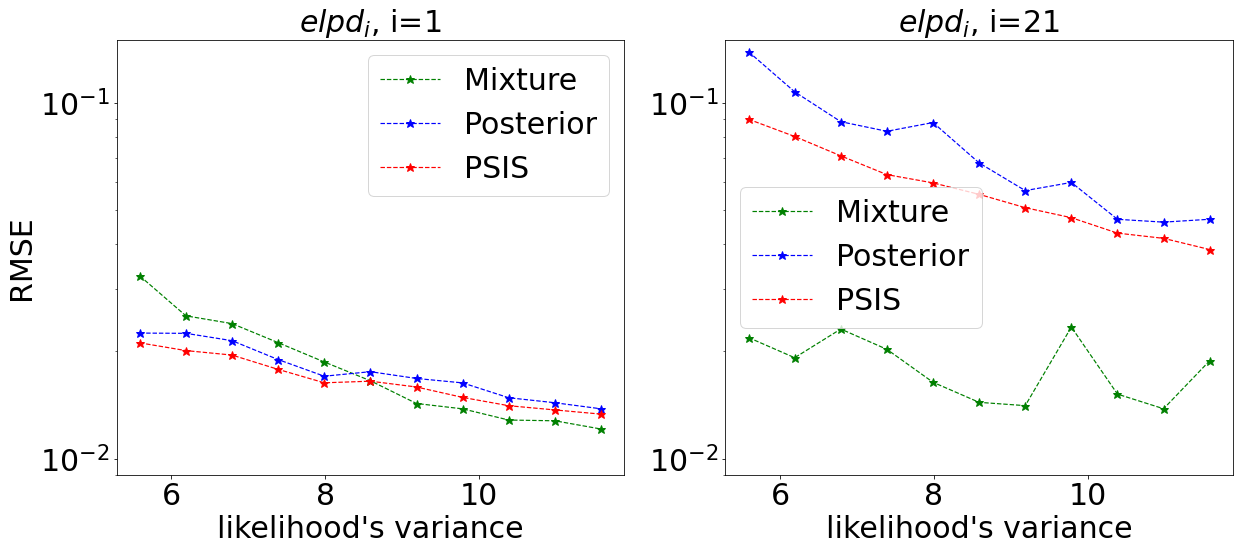

In [54]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1.plot(np.array(variances), rmses_mix[0,::], color="green", marker="*", ms="9", linestyle="--", lw=1.2, label="Mixture")
ax1.plot(np.array(variances), rmses_post[0,::], color="blue", marker="*",ms="9", linestyle="--", lw=1.2, label="Posterior")
ax1.plot(np.array(variances), rmses_psis[0,::], color="red", marker="*", ms="9",linestyle="--", lw=1.2, label="PSIS")

ax2.plot(np.array(variances), rmses_mix[20,::], color="green", marker="*", ms="9",linestyle="--", lw=1.2, label="Mixture")
ax2.plot(np.array(variances), rmses_post[20,::], color="blue", marker="*", ms="9",linestyle="--", lw=1.2, label="Posterior")
ax2.plot(np.array(variances), rmses_psis[20,::], color="red", marker="*", ms="9",linestyle="--", lw=1.2, label="PSIS")


ax1.set_title("$elpd_i$, i=1", size=30)
ax2.set_title("$elpd_i$, i=21", size=30)
ax1.set_ylabel("RMSE",size=30)
ax1.set_xlabel("likelihood's variance",size=30)
ax2.set_xlabel("likelihood's variance",size=30)

ax1.set_ylim([0.009,0.15])
ax2.set_ylim([0.009,0.15])
ax1.set_yscale("log")
ax2.set_yscale("log")

ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax2.legend()
ax1.legend(fontsize=30)
ax2.legend(fontsize=30)
